##Feature Learner Demo

The file model_wrappers.py has a collection of feature extractors that all share one interface.

The shared interface is:
    learner = Learner_Class(train_X, train_y)
    learner.fit(train_X, train_y, validation_X, validation_y)
    features = learner.get_fearures(any_X)

The X inputs should be numpy arrays with the shape set_length x channels x number_of_samples

The y inputs should be 1d numpy arrays (not one-hot)

The features will always be returned as a numpy array with shape length_of_X x 64, or length_of_X x 18 for the engineered features.

In [6]:
#Make sure local file structure exists
import os

if not os.path.exists('temp'):
    os.mkdir('temp')

In [20]:
#Gotta have Libraries
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from model_wrappers import SimCLR_C, Engineered_Features
from load_data_time_series.HAR.UniMiB_SHAR.unimib_shar_adl_load_dataset import unimib_load_dataset

In [21]:
def channel_swap(X : np.ndarray) -> np.ndarray:
    """
    Return channels first array from channels last or vice versa
    """
    assert X.ndim == 3, "Data must be 3-dimensional to channel swap"
    return np.reshape(X, (X.shape[0], X.shape[2], X.shape[1]))

In [19]:
#Import UniMiB SHAR dataset
X_train, y_train, X_val, y_val, X_test, y_test = unimib_load_dataset(
            incl_xyz_accel=True, incl_rms_accel=False, incl_val_group=True
)

#Put X arrays into channels-first format
X_train = channel_swap(X_train)
X_test = channel_swap(X_test)
X_val = channel_swap(X_val)

#Make y arrays 1d
y_train = np.array(np.argmax(y_train, axis=-1))
y_val = np.array(np.argmax(y_val, axis=-1))
y_test = np.array(np.argmax(y_test, axis=-1))

Raw data     shape        object type              data type
-----------  -----------  -----------------------  -----------
adl_data:    (7579, 453)  <class 'numpy.ndarray'>  float64
adl_labels:  (7579, 3)    <class 'numpy.ndarray'>  uint8
adl_names:   (9, 1)       <class 'numpy.ndarray'>  object
Reshaped data    shape           object type              data type
---------------  --------------  -----------------------  -----------
adl_data:        (7579, 151, 3)  <class 'numpy.ndarray'>  float64
adl_labels:      (7579, 3)       <class 'numpy.ndarray'>  uint8
adl_names:       (9, 1)          <class 'numpy.ndarray'>  object
x/y_train shape  (4601, 151, 3) (4601,)
x/y_validation shape  (1454, 151, 3) (1454,)
x/y_test shape   (1524, 151, 3) (1524,)
After one-hot encoding
x/y_train shape  (4601, 151, 3) (4601, 9)
x/y_validation shape  (1454, 151, 3) (1454, 9)
x/y_test shape   (1524, 151, 3) (1524, 9)


In [22]:
#Summon two feature learners
engineered_extractor = Engineered_Features(X_train, y_train)
simclr_extractor = SimCLR_C(X_train, y_train)

#Fit both extractors
engineered_extractor.fit(X_train, y_train, X_val, y_val)
simclr_extractor.fit(X_train, y_train, X_val, y_val)

#Get two feature sets for our UniMiB data
features_1_train = engineered_extractor.get_features(X_train)
features_1_test = engineered_extractor.get_features(X_test)

features_2_train = simclr_extractor.get_features(X_train)
features_2_test = simclr_extractor.get_features(X_test)


Epoch : 0

Epoch : 0

Epoch : 0

Epoch : 0

Epoch : 0
Saving model at 0 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps80_lr0.001_bs32_aug1t_flip_aug2noise_dim-pdim64-64_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru0.pt
Train Loss     : 1.5941
Train Loss     : 1.5941
Train Loss     : 1.5941
Train Loss     : 1.5941
Train Loss     : 1.5941
update
Val Loss     : 1.7053
Val Loss     : 1.7053
Val Loss     : 1.7053
Val Loss     : 1.7053
Val Loss     : 1.7053

Epoch : 1

Epoch : 1

Epoch : 1

Epoch : 1

Epoch : 1
Saving model at 1 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps80_lr0.001_bs32_aug1t_flip_aug2noise_dim-pdim64-64_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru1.pt
Train Loss     : 0.9313
Train Loss     : 0.9313
Train Loss     : 0.9313
Train Loss     : 0.9313
Train Loss     : 0.9313
update
Val Loss     : 1.3699
Val Loss     : 1.3699
Val Loss     : 1.3699
Val Loss     : 1.3699
Val Loss     : 1.3699

Epoch : 2

Epoch : 2

E

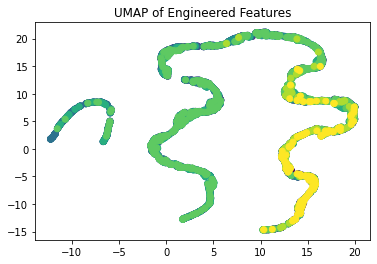

In [23]:
#Visualize Feature Set 1
reducer = umap.UMAP(n_neighbors=15, n_components=2)
embedding = reducer.fit_transform(features_1_train)
plt.figure()
plt.scatter(embedding[:,0], embedding[:,1], c=y_train)
plt.title("UMAP of Engineered Features")
plt.show()

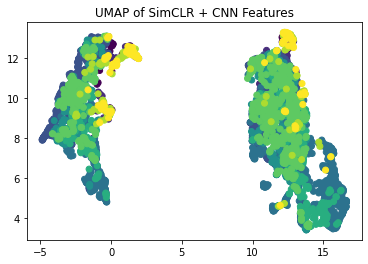

In [24]:
#Visualize Feature Set 2
reducer = umap.UMAP(n_neighbors=15, n_components=2)
embedding = reducer.fit_transform(features_2_train)
plt.figure()
plt.scatter(embedding[:,0], embedding[:,1], c=y_train)
plt.title("UMAP of SimCLR + CNN Features")
plt.show()

In [27]:
#Clean up after ourselves

import shutil

if os.path.exists('temp/'):
    shutil.rmtree('temp/')
if os.path.exists('UniMiB-SHAR/'):
    shutil.rmtree('UniMiB-SHAR/')